 # Importar librerias

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
 
from tensorflow.keras.preprocessing import image

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, concatenate, MaxPooling2D, AveragePooling2D, Conv1D, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import reduce_sum

import tensorflow as tf


# Preparar datos

## importar datos

In [2]:
meta_data = pd.read_excel('data_preliminar_trabajo_de_grado.Xlsx')
labels= meta_data['id_referencia'].unique()
labels_train = [str(x) for x in labels ]
train= ImageDataGenerator() \
.flow_from_directory(directory='data_mk/train',target_size=(512, 512), classes=labels_train, batch_size=1)

Found 250 images belonging to 125 classes.


In [3]:
# separamos imagen de clasiifcador
x_train = []
y_train = []
labels_train = []

for i in range (0, len(train.labels)):
    x = np.squeeze(train[i][0])
    x_train.append(x)
    
    y = np.squeeze(train[i][1])
    y_train.append(y)
    
    labels = y.tolist()
    labels = labels.index(1)
    labels_train.append(labels)
    
x_train = np.array(x_train)
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
labels_train = np.array(labels_train)
print(labels_train.shape)

(250, 512, 512, 3)
(250, 125)
(250,)


In [4]:
# función para graficar tripletas
def plot_triplet (triplet):
        plt.figure(figsize=(6, 2))
        for i in range (0, 3):
            plt.subplot(1, 3, i + 1  )
            plt.imshow(np.squeeze((triplet[i].astype('uint8'))))
            plt.xticks=([])
            plt.yticks([])
            plt.show()

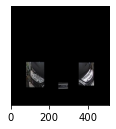

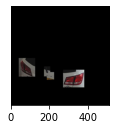

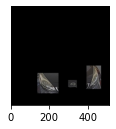

In [5]:
# prueba de función de plot_triplet
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [6]:
# creación de tripletas
def create_batch (batch_size=1, counter=0):
    anchors = np.zeros((batch_size, 512, 512, 3))
    positives = np.zeros((batch_size, 512, 512, 3))
    negatives = np.zeros((batch_size, 512, 512, 3))
    yy_train = np.zeros((batch_size, 125 ))
    
    for i in range(0, batch_size):
        anc = x_train[counter]
        yy = y_train[counter]
        y = labels_train[counter]
        
        indices_for_pos = np.squeeze(np.where(labels_train == y))
        indices_for_neg = np.squeeze(np.where(labels_train != y))
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
    
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        yy_train[i] = yy
            
    return [anchors, positives, negatives, yy_train]

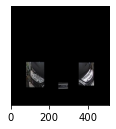

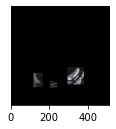

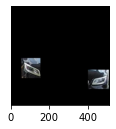

In [7]:
# muestra de tripleta
triplet = create_batch(1)[:3]
plot_triplet(triplet)

In [8]:
## función para generar dataset de entrenamiento
def data_generator (batch_size = 1, emb_dim=125):
    counter = 0
    while True:
        x = create_batch(batch_size, counter)[:3]
        y = create_batch(batch_size, counter)[-1]
        if counter < len(train.labels)-1 :
            counter = counter + 1
        else:
            counter = 0
        yield x, y

# Función de perdida

In [9]:
def triplet_loss (alpha=0.3, poolsize=125):
    def loss (y_true, y_pred):
        anc, pos, neg = y_pred[:, :poolsize], y_pred[:, poolsize:2*poolsize], y_pred[:, 2*poolsize:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

# Modelado

## embeding

In [10]:

in_lb = Input(shape=(512,512, 3))

#backbone
rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(in_lb)

# latt
ap = AveragePooling2D(pool_size=(16, 16), strides=16)(rn50)
sum= reduce_sum(ap, axis=2, keepdims= True)
fl_sum =Flatten()(sum)
acti = Activation('relu')(fl_sum)
bn = BatchNormalization()(acti)
w= Dense(2048, activation='softmax')(bn)

# final layer
apf = Flatten()(ap)
dot = tf.multiply(apf, w)


latt = Model(in_lb, dot)
latt.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x0000018A92FD6A30>>

## siamese embeding

In [11]:
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = latt(in_anc)
emb_pos = latt(in_pos)
emb_neg = latt(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_lb =  Model ([in_anc, in_pos, in_neg], emb_conca)

net_lb.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                          

## entrenamiento del modelo

In [12]:
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_lb.compile(loss=triplet_loss(alpha=0.3, poolsize=2048),  optimizer='adam', metrics=['accuracy'])
net_lb.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 1267s 5s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 1235s 5s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 3/15
250/250 [==============================] - 1119s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 1078s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 5/15
250/250 [==============================] - 1073s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 6/15
250/250 [==============================] - 1074s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 7/15
250/250 [==============================] - 1111s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 8/15
250/250 [==============================] - 1046s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 9/15
250/250 [==============================] - 1104s 4s/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 10/15
250/250 [=========================

KeyboardInterrupt: 